In [22]:
##TODO -> try LLM models (chat gpt or bert), 
# would be good to use both title and body

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import requests
from tqdm import tqdm
import xgboost as xgb
tqdm.pandas()

In [24]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")

In [36]:
# Actually there is no need to split it here, only to stay consistent with other notebooks
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

In [64]:
x_train = x_train[:30]
y_train = y_train[:30]

In [65]:
x_test = x_test[:30]
y_test = y_test[:30]

# Direct prompt 

In [26]:
file_path = r"C:\Users\Mateusz\Desktop\api_key_chat_gpt_kubita.txt" 

with open(file_path, 'r') as file:
    api_key = file.read()

In [52]:
# We can play with prompt :)
def get_chat_gpt_answer(title):
    res = requests.post(f"https://api.openai.com/v1/chat/completions",
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    },
    json={
      "model": "gpt-4o",
      "messages": [
          {
              "role": "user",
              "content": f"Decide if this is fake news or not. If fake news return 1, if not fake news return 0, nothing more. This is title:{title}"
          },
      ],
    }).json()

    # Sometimes the model returns string explanation, e.g. 
    # "I'm unable to provide real-time news verification or access real-time information. 
    # Please consult reliable news sources or fact-checking websites to determine the authenticity of this news.
    answer = res["choices"][0]["message"]["content"]
    
    try:
        answer_int = int(answer)
    except:
        answer_int = 0
        
    return answer_int

In [53]:
get_chat_gpt_answer('Donald Trump gives incredible speech in California. ')

1

In [54]:
predictions = x_test.progress_apply(get_chat_gpt_answer)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.76it/s]


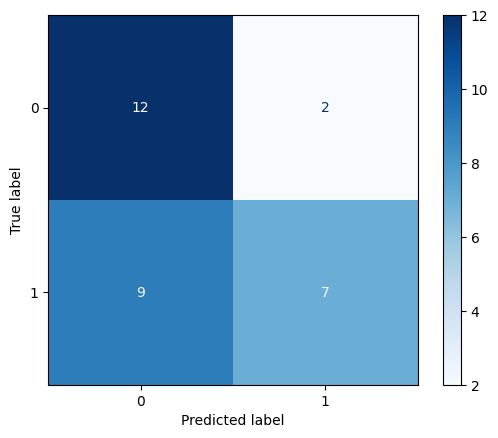

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Embeddings

In [58]:
def return_embeddings_chat(prompt):
    res = requests.post(f"https://api.openai.com/v1/embeddings",
        headers = {
          "Content-Type": "application/json",
          "Authorization": f"Bearer {api_key}"
        },
        json={
          "model": "text-embedding-3-large",
          "encoding_format": "float",
          "input": f"{prompt}"
        }).json()
    return res["data"][0]["embedding"]

In [66]:
return_embeddings_chat('Hello everyone')[:3]

[-0.049212195, 0.01368497, -1.7196902e-05]

In [ ]:
embeddings_train = x_train.progress_apply(return_embeddings_chat)
embeddings_x_train_df = pd.DataFrame(embeddings_train.tolist())

embeddings_test = x_test.progress_apply(return_embeddings_chat)
embeddings_x_test_df = pd.DataFrame(embeddings_test.tolist())

 13%|███████████                                                                        | 4/30 [00:02<00:19,  1.31it/s]

In [68]:
embeddings_x_train_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,-0.060532,-0.019451,-0.012808,0.003376,-0.001247,-0.008318,0.007637,-0.008108,-0.025349,0.033298,...,-0.012159,0.013171,-0.011413,-0.000783,-0.009121,0.001606,-0.004707,0.005146,-0.013528,-0.014840
1,0.000616,0.004269,-0.002592,-0.032668,0.004036,-0.000418,0.012241,0.007834,-0.032241,-0.020899,...,0.001450,0.016598,-0.011744,0.006422,-0.015064,0.011493,0.009733,0.014196,0.003260,0.013530
2,-0.018173,-0.029674,-0.022900,-0.007121,-0.008177,-0.017074,0.007545,0.017870,-0.020878,0.022824,...,-0.011930,-0.001204,-0.006995,0.005084,-0.034249,-0.002144,0.021232,-0.001133,0.003017,-0.013775
3,-0.008514,-0.006345,0.005883,-0.014293,0.024856,0.000978,0.022107,-0.013147,-0.000523,-0.013504,...,0.000620,0.020478,0.001639,0.003440,-0.003659,-0.006453,0.005899,-0.014484,0.006395,0.017716
4,0.018442,-0.030865,-0.016436,-0.006502,-0.035598,-0.019162,0.010270,0.021490,0.019346,-0.012936,...,0.001064,0.013365,0.020081,0.012346,0.006529,0.016267,0.012859,-0.005365,0.008195,-0.011274


# Model fitting

In [73]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [ ]:
pred_xgb = xgb_model.predict(xv_test)

cm = confusion_matrix(y_test, pred_xgb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, pred_xgb))